### Link to results
[Proportion of peaks with hits](#peaks-with-hits)

[Examples of motif hits](#example-hits)

[Homotypic density of motifs in peaks](#density)

[Co-occurrence of motifs in peaks](#co-occurrence)

[Distance between co-occurring motifs](#distance)

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from tfmodisco_hit_scoring import import_tfmodisco_hits
from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import viz_sequence
import h5py
import numpy as np
import pandas as pd
import pomegranate
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

/tmp/ipykernel_282530/3902103791.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define constants and paths

In [3]:
# FOSL2 cutnrun maxfl120 & minfl150

# Define parameters/fetch arguments
tfm_results_path_max = "/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/tfmodisco_results_FOSL2_120"
shap_scores_path_max = "/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/shap_scores_FOSL2_120"
peak_bed_paths = ["/home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed"]
motif_hits_path_max = "/home/katie/bp_repo/reports/tfm_hits/FOSL2/cutnrun_maxfl120_jan9_COUNTS_HEAD/tfm_matches.bed"

print("TF-MoDISco results path: %s" % tfm_results_path_max)
print("DeepSHAP scores path: %s" % shap_scores_path_max)
print("Peaks path: %s" % peak_bed_paths[0])
print("Motif hits path: %s" % motif_hits_path_max)

tfm_results_path_min = "/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/tfmodisco_results_FOSL2_150"
shap_scores_path_min = "/home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/shap_scores_FOSL2_150"
peak_bed_paths = ["/home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed"]
motif_hits_path_min = "/home/katie/bp_repo/reports/tfm_hits/FOSL2/cutnrun_minfl150_jan9_COUNTS_HEAD/tfm_matches.bed"

print("TF-MoDISco results path: %s" % tfm_results_path_min)
print("DeepSHAP scores path: %s" % shap_scores_path_min)
print("Peaks path: %s" % peak_bed_paths[0])
print("Motif hits path: %s" % motif_hits_path_min)

TF-MoDISco results path: /home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/tfmodisco_results_FOSL2_120
DeepSHAP scores path: /home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/shap_scores_FOSL2_120
Peaks path: /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed
Motif hits path: /home/katie/bp_repo/reports/tfm_hits/FOSL2/cutnrun_maxfl120_jan9_COUNTS_HEAD/tfm_matches.bed
TF-MoDISco results path: /home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/tfmodisco_results_FOSL2_150
DeepSHAP scores path: /home/katie/bp_repo/pipeline_outputs/fosl2_cutnrun_120_150_jan9_COUNTS_HEAD/shap_scores_FOSL2_150
Peaks path: /home/katie/bp_repo/research/data/cutnrun/FOSL2/FOSL2.bed
Motif hits path: /home/katie/bp_repo/reports/tfm_hits/FOSL2/cutnrun_minfl150_jan9_COUNTS_HEAD/tfm_matches.bed


In [4]:
# Constants
input_length = 2114
hyp_score_key = "hyp_scores"
motif_tfm_sim_perc_cutoff = 0.05  # For TF-MoDISco hits
motif_tfm_imp_perc_cutoff = 0.05  # For TF-MoDISco hits

seed = 20210412

### Helper functions
For plotting and organizing things

In [5]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    pfm = trim_motif_by_ic(pfm, pfm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = pfm
    return pfms

In [6]:
def import_motif_hits(motif_hits_path):
    """
    Imports the motif hits, which is the output of TF-MoDISco hit scanning.
    """
    with open(motif_hits_path, "r") as f:
        cols = next(f).split("\t")
    assert len(cols) == 16

    hit_table = import_tfmodisco_hits(motif_hits_path)

    # Sort by aggregate similarity and drop duplicates (by strand)
    hit_table = hit_table.sort_values("agg_sim")
    hit_table = hit_table.drop_duplicates(["chrom", "start", "end", "peak_index"], keep="last")
    return hit_table

In [7]:
def estimate_mode(x_values, bins=200, levels=1):
    """
    Estimates the mode of the distribution using `levels`
    iterations of histograms.
    """
    hist, edges = np.histogram(x_values, bins=bins)
    bin_mode = np.argmax(hist)
    left_edge, right_edge = edges[bin_mode], edges[bin_mode + 1]
    if levels <= 1:
        return (left_edge + right_edge) / 2
    else:
        return estimate_mode(
            x_values[(x_values >= left_edge) & (x_values < right_edge)],
            bins=bins,
            levels=(levels - 1)
        )

In [8]:
def fit_tight_exponential_dist(x_values, mode=0, percentiles=np.arange(0.05, 1, 0.05)):
    """
    Given an array of x-values and a set of percentiles of the distribution,
    computes the set of lambda values for an exponential distribution if the
    distribution were fit to each percentile of the x-values. Returns an array
    of lambda values parallel to `percentiles`. The exponential distribution
    is assumed to have the given mean/mode, and all data less than this mode
    is tossed out when doing this computation.
    """
    assert np.min(percentiles) >= 0 and np.max(percentiles) <= 1
    x_values = x_values[x_values >= mode]
    per_x_vals = np.percentile(x_values, percentiles * 100)
    return -np.log(1 - percentiles) / (per_x_vals - mode)

In [9]:
def exponential_pdf(x_values, lamb):
    return lamb * np.exp(-lamb * x_values)
def exponential_cdf(x_values, lamb):
    return 1 - np.exp(-lamb * x_values)

In [10]:
def filter_tfm_peak_hits(
    hit_table, sim_score_column="agg_sim", imp_score_column="imp_frac_score",
    sim_perc_cutoff=0.05, imp_perc_cutoff=0.05
):
    """
    Filters the table of peak hits by the score defined by
    `score_column` by filtering out low-percentile hits in terms of both
    similarity to the cluster, and importance score.
    For the similarity score, a mixed model is fit to the distribution of
    simiarities, and the low percentiles of the exponential component (the
    null) are cut off. For the importance score filter, a Gaussian null
    is fit to the part of the score distribution to the left of the mode
    (mirroring it around the mode), and then applying the percentile
    cut-off. Returns a reduced hit table of the same format, and a figure
    of the similarity distribution and the importance distribution.
    """
    # Similarity filtering
    
    sim_scores = hit_table[sim_score_column].values
    sim_scores_finite = sim_scores[np.isfinite(sim_scores)]
    
    sim_mode = estimate_mode(sim_scores_finite)
    sim_scores_below_mode = sim_scores_finite[sim_scores_finite <= sim_mode]
    sim_scores_symmetric = np.concatenate([sim_scores_below_mode, (2 * sim_mode) - sim_scores_below_mode])

    sim_null_model = pomegranate.NormalDistribution.from_samples(sim_scores_symmetric)
    sim_null_model.fit(sim_scores_symmetric)

    sim_x = np.linspace(np.min(sim_scores_symmetric), np.max(sim_scores_symmetric), 200)
    sim_pdf = sim_null_model.probability(sim_x)
    
    sim_score_fig, ax = plt.subplots(figsize=(20, 6))
    ax.hist(sim_scores_finite, bins=500, density=True, alpha=0.3, label="Similarity scores")
    ax.hist(sim_scores_symmetric, bins=500, density=True, alpha=0.3, label="Null component")
    ax.plot(sim_x, sim_pdf, label="Fitted null model")
    mean, std = sim_null_model.parameters
    sim_thresh = scipy.stats.norm.ppf(sim_perc_cutoff, mean, std)
    ax.axvline(sim_thresh)
    plt.legend()
    plt.show()
    
    # Importance score filtering
    
    imp_scores = hit_table[imp_score_column].values
    imp_scores_finite = imp_scores[np.isfinite(imp_scores)]

    imp_mode = estimate_mode(imp_scores_finite)
    imp_scores_below_mode = imp_scores_finite[imp_scores_finite <= imp_mode]
    imp_scores_symmetric = np.concatenate([imp_scores_below_mode, (2 * imp_mode) - imp_scores_below_mode])

    imp_null_model = pomegranate.NormalDistribution.from_samples(imp_scores_symmetric)
    imp_null_model.fit(imp_scores_symmetric)

    imp_x = np.linspace(np.min(imp_scores_symmetric), np.max(imp_scores_symmetric), 200)
    imp_pdf = imp_null_model.probability(imp_x)
    
    imp_score_fig, ax = plt.subplots(figsize=(20, 6))
    ax.hist(imp_scores_finite, bins=500, density=True, alpha=0.3, label="Importance scores")
    ax.hist(imp_scores_symmetric, bins=500, density=True, alpha=0.3, label="Null component")
    ax.plot(imp_x, imp_pdf, label="Fitted null model")
    mean, std = imp_null_model.parameters
    imp_thresh = scipy.stats.norm.ppf(imp_perc_cutoff, mean, std)
    ax.axvline(imp_thresh)
    plt.legend()
    plt.show()

    return hit_table.loc[
        (hit_table[sim_score_column] >= sim_thresh) & (hit_table[imp_score_column] >= imp_thresh)
    ].reset_index(drop=True), (sim_score_fig, imp_score_fig)

In [11]:
def get_peak_hits(peak_table, hit_table):
    """
    For each peak, extracts the set of motif hits that fall in that peak.
    Returns a list mapping peak index to a subtable of `hit_table`. The index
    of the list is the index of the peak table.
    """
    peak_hits = [pd.DataFrame(columns=list(hit_table))] * len(peak_table)
    for peak_index, matches in tqdm.notebook.tqdm(hit_table.groupby("peak_index")):
        # Check that all of the matches are indeed overlapping the peak
        peak_row = peak_table.iloc[peak_index]
        chrom, start, end = peak_row["chrom"], peak_row["peak_start"], peak_row["peak_end"]
        assert np.all(matches["chrom"] == chrom)
        assert np.all((matches["start"] < end) & (start < matches["end"]))
        
        peak_hits[peak_index] = matches
    return peak_hits

In [12]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

### Import hit results

In [13]:
# Import the PFMs
pfms_max = import_tfmodisco_motifs(tfm_results_path_max)
motif_keys_max = list(pfms_max.keys())

pfms_min = import_tfmodisco_motifs(tfm_results_path_min)
motif_keys_min = list(pfms_min.keys())

In [14]:
# Import peaks
peak_table = import_peak_table(peak_bed_paths)

# Expand to input length
peak_table["peak_start"] = \
    (peak_table["peak_start"] + peak_table["summit_offset"]) - (input_length // 2)
peak_table["peak_end"] = peak_table["peak_start"] + input_length

In [15]:
# Import DeepSHAP scores
hyp_scores_max, act_scores_max, one_hot_seqs_max, shap_coords_max = import_shap_scores(
    shap_scores_path_max, hyp_score_key, center_cut_size=None, remove_non_acgt=False
)

# Import DeepSHAP scores
hyp_scores_min, act_scores_min, one_hot_seqs_min, shap_coords_min = import_shap_scores(
    shap_scores_path_min, hyp_score_key, center_cut_size=None, remove_non_acgt=False
)


Importing SHAP scores: 100%|██████████████████| 183/183 [00:09<00:00, 18.54it/s]

Importing SHAP scores: 100%|██████████████████| 183/183 [00:09<00:00, 18.60it/s]


In [16]:
# Limit SHAP coordinates/scores to only those with matching peak coordinates
shap_coords_table_max = pd.DataFrame(shap_coords_max, columns=["chrom", "start", "end"])
shap_coords_table_min = pd.DataFrame(shap_coords_min, columns=["chrom", "start", "end"])
peak_coords_table = peak_table[["chrom", "peak_start", "peak_end"]]

order_inds_max = peak_coords_table.merge(
    shap_coords_table_max.reset_index(), how="left", left_on=["chrom", "peak_start", "peak_end"],
    right_on=["chrom", "start", "end"]
)["index"].values
order_inds_max = np.nan_to_num(order_inds_max, nan=-1).astype(int)

shap_coords_max = shap_coords_max[order_inds_max]
hyp_scores_max = hyp_scores_max[order_inds_max]
act_scores_max = act_scores_max[order_inds_max]
one_hot_seqs_max = one_hot_seqs_max[order_inds_max]

# Whenever a SHAP coord did not exist in the peak table, set to 0
# This ensures that when we search for matches of DeepSHAP scores that don't
# exist, we will find nothing
shap_coords_max[order_inds_max < 0] = 0
hyp_scores_max[order_inds_max < 0] = 0
act_scores_max[order_inds_max < 0] = 0
one_hot_seqs_max[order_inds_max < 0] = 0


order_inds_min = peak_coords_table.merge(
    shap_coords_table_min.reset_index(), how="left", left_on=["chrom", "peak_start", "peak_end"],
    right_on=["chrom", "start", "end"]
)["index"].values
order_inds_min = np.nan_to_num(order_inds_min, nan=-1).astype(int)

shap_coords_min = shap_coords_min[order_inds_min]
hyp_scores_min = hyp_scores_min[order_inds_min]
act_scores_min = act_scores_min[order_inds_min]
one_hot_seqs_min = one_hot_seqs_min[order_inds_min]

# Whenever a SHAP coord did not exist in the peak table, set to 0
# This ensures that when we search for matches of DeepSHAP scores that don't
# exist, we will find nothing
shap_coords_min[order_inds_min < 0] = 0
hyp_scores_min[order_inds_min < 0] = 0
act_scores_min[order_inds_min < 0] = 0
one_hot_seqs_min[order_inds_min < 0] = 0

In [17]:
# Import motif hits results
hit_table_max = import_motif_hits(motif_hits_path_max)
hit_table_min = import_motif_hits(motif_hits_path_min)

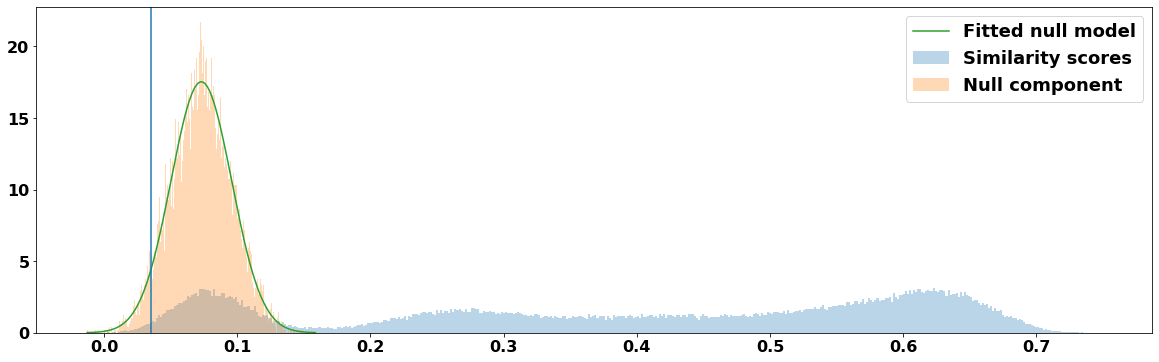

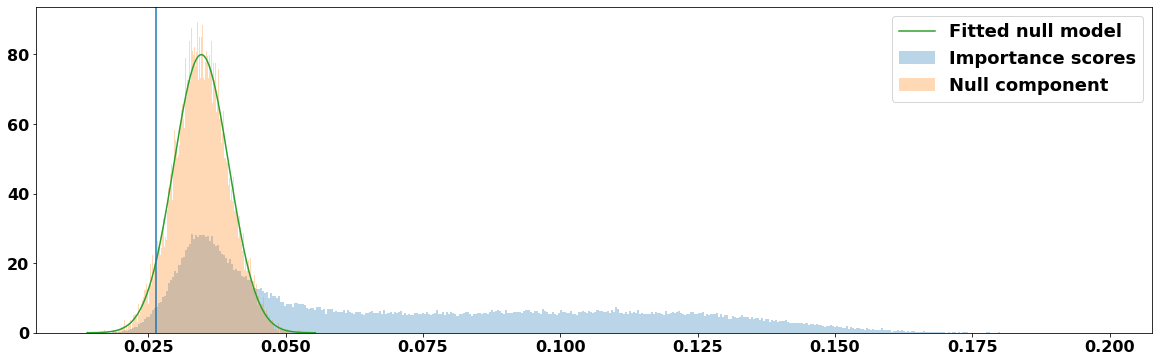

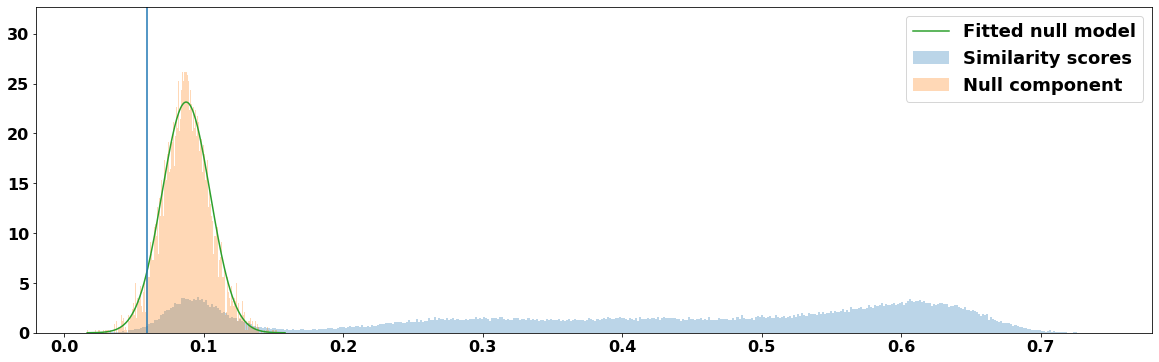

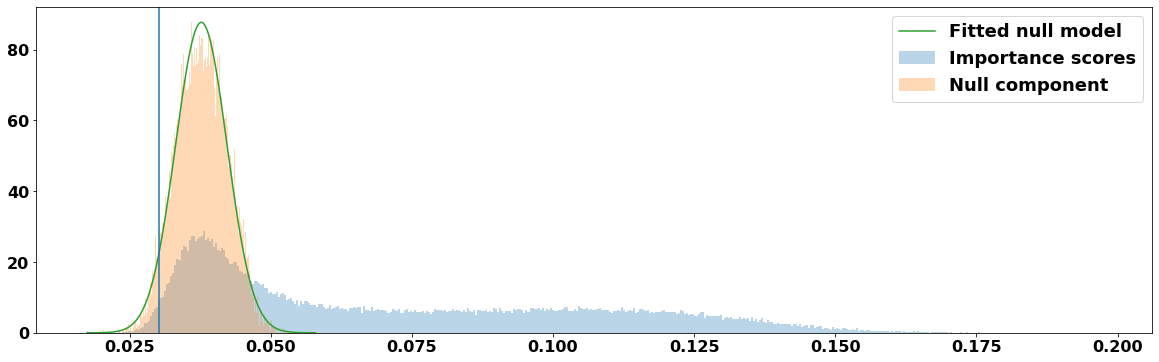

In [18]:
# Filter motif hit table
hit_table_filtered_max, (sim_score_fig, imp_score_fig) = filter_tfm_peak_hits(
    hit_table_max, sim_perc_cutoff=motif_tfm_sim_perc_cutoff, imp_perc_cutoff=motif_tfm_imp_perc_cutoff
)

hit_table_filtered_min, (sim_score_fig, imp_score_fig) = filter_tfm_peak_hits(
    hit_table_min, sim_perc_cutoff=motif_tfm_sim_perc_cutoff, imp_perc_cutoff=motif_tfm_imp_perc_cutoff
)

In [19]:
assert not hit_table_filtered_max.empty, "Filtered out all %d original hits" % len(hit_table_max)
assert not hit_table_filtered_min.empty, "Filtered out all %d original hits" % len(hit_table_min)

In [20]:
# Match peaks to motif hits
peak_hits_max = get_peak_hits(peak_table, hit_table_filtered_max)
peak_hits_min = get_peak_hits(peak_table, hit_table_filtered_min)

  0%|          | 0/40169 [00:00<?, ?it/s]

  0%|          | 0/39837 [00:00<?, ?it/s]

## my code

### For CTCF and FOSL2 CUT&RUN, we saw that the core motif (CCACCAGGGGG for CTCF; TGACTGA for FOSL2) had motif hits in a subset of peaks for the short-fragment-length task and the long-fragment-length task. Do these motif hits occur in disjoint peaks? Do they add up to represent all CUT&RUN peaks?

In [21]:
len(peak_hits_max)  # 1 entry for each peak in peak_table
# same len as peak_hits_min but very different contents

45597

In [22]:
peak_hits_max[17020]  # list mapping peak index to a subtable of `hit_table`

,chrom,start,end,key,strand,peak_index,imp_total_signed_score,imp_total_score,imp_frac_score,imp_ic_avg_score,agg_sim,mod_delta,mod_precision,mod_percentile,fann_perclasssum_perc,fann_perclassavg_perc
6816,chr4,38967229,38967238,0_0,+,17020,0.007661,0.007661,0.029189,0.001507,0.078321,0.000071,1.0,0.203373,0.00000,0.00000
83840,chr4,38967426,38967435,0_0,+,17020,0.033124,0.033124,0.126208,0.006058,0.680376,0.000123,1.0,0.450397,0.97123,0.97123


#### a) Calculate how many peaks have core motif hit and a motif hit in general from max and/or min tasks (just generally, how many peaks have some motif hit?) 

In [23]:
hit_table_filtered_max_0_0 = hit_table_filtered_max.loc[hit_table_filtered_max.key == '0_0',:]  # removes 35 non-core motif hits
hit_table_filtered_min_0_0 = hit_table_filtered_min.loc[hit_table_filtered_min.key == '0_0',:]  # removes 609 non-core motif hits

In [24]:
np.unique(peak_table.peak_end - peak_table.peak_start)

array([2114])

In [25]:
# how many peaks have core motif hit from either task
unique_peaks_max = set(hit_table_filtered_max_0_0.peak_index.unique())  # unique peaks with at least 1 core motif hit
unique_peaks_min = set(hit_table_filtered_min_0_0.peak_index.unique())

print(f'Number of unique peaks from max task with >0 core motif hit: {len(unique_peaks_max)}')
print(f'Number of unique peaks from min task with >0 core motif hit: {len(unique_peaks_min)}')
print(f'Number of unique peaks from either task with >0 core motif hit: {len(unique_peaks_max | unique_peaks_min)}')
print(f'Percent of peaks with >0 core motif hit from either task: {round(len(unique_peaks_max | unique_peaks_min) / len(peak_hits_max) * 100, 1)}%')


Number of unique peaks from max task with >0 core motif hit: 40169
Number of unique peaks from min task with >0 core motif hit: 39837
Number of unique peaks from either task with >0 core motif hit: 42126
Percent of peaks with >0 core motif hit from either task: 92.4%


In [26]:
# how many peaks have any general motif hit from either task
ORIG_unique_peaks_max = set(hit_table_filtered_max.peak_index.unique())  # unique peaks with at least 1 general motif hit
ORIG_unique_peaks_min = set(hit_table_filtered_min.peak_index.unique())

print(f'Number of unique peaks from max task with >0 core motif hit: {len(ORIG_unique_peaks_max)}')
print(f'Number of unique peaks from min task with >0 core motif hit: {len(ORIG_unique_peaks_min)}')
print(f'Number of unique peaks from either task with >0 core motif hit: {len(ORIG_unique_peaks_max | ORIG_unique_peaks_min)}')
print(f'Percent of peaks with >0 general motif hit from either task: {round(len(ORIG_unique_peaks_max | ORIG_unique_peaks_min) / len(peak_hits_max) * 100, 1)}%')


Number of unique peaks from max task with >0 core motif hit: 40169
Number of unique peaks from min task with >0 core motif hit: 39837
Number of unique peaks from either task with >0 core motif hit: 42126
Percent of peaks with >0 general motif hit from either task: 92.4%


#### b) Calculate how many peaks have core motif hit from JUST max task, from JUST min task, and from BOTH tasks

In [27]:
print(f'Number of unique peaks with >0 core motif hit from JUST MAX task: {len(unique_peaks_max.difference(unique_peaks_min))}')
print(f'Percent of unique peaks with >0 core motif hit from JUST MAX task: {round(len(unique_peaks_max.difference(unique_peaks_min)) / len(peak_hits_max) * 100, 1)}%')


Number of unique peaks with >0 core motif hit from JUST MAX task: 2289
Percent of unique peaks with >0 core motif hit from JUST MAX task: 5.0%


In [28]:
print(f'Number of unique peaks with >0 core motif hit from JUST MIN task: {len(unique_peaks_min.difference(unique_peaks_max))}')
print(f'Percent of unique peaks with >0 core motif hit from JUST MIN task: {round(len(unique_peaks_min.difference(unique_peaks_max)) / len(peak_hits_max) * 100, 1)}%')


Number of unique peaks with >0 core motif hit from JUST MIN task: 1957
Percent of unique peaks with >0 core motif hit from JUST MIN task: 4.3%


In [29]:
print(f'Number of unique peaks with >0 core motif hit from BOTH TASKS: {len(unique_peaks_max & unique_peaks_min)}')
print(f'Percent of unique peaks with >0 core motif hit from BOTH TASKS: {round(len(unique_peaks_max & unique_peaks_min) / len(peak_hits_max) * 100, 1)}%')


Number of unique peaks with >0 core motif hit from BOTH TASKS: 37880
Percent of unique peaks with >0 core motif hit from BOTH TASKS: 83.1%


In [31]:
## these percentages add up to 92.4%, as expected

#### c) Calculate how many peaks have NO core motif hit from either task

In [31]:
print(f'Number of unique peaks with no core motif hit: {len(peak_hits_max) - len(unique_peaks_max | unique_peaks_min)}')
print(f'Percent of unique peaks with no core motif hit: {round((len(peak_hits_max) - len(unique_peaks_max | unique_peaks_min)) / len(peak_hits_max) * 100, 1)}%')
# yep sounds right


Number of unique peaks with no core motif hit: 3471
Percent of unique peaks with no core motif hit: 7.6%


In [34]:
# example for future reference
setty1 = {1, 2, 3}
setty2 = {2, 4, 6}
print(f'setty1: {setty1}\nsetty2: {setty2}')
print(f'setty1 symmetric difference with setty2: {setty1.symmetric_difference(setty2)}')
print(f'setty1 difference with setty2: {setty1.difference(setty2)}')
print(f'setty2 difference with setty1: {setty2.difference(setty1)}')
print(f'setty1 intersection with setty2: {setty1.intersection(setty2)}')

setty1: {1, 2, 3}
setty2: {2, 4, 6}
setty1 symmetric difference with setty2: {1, 3, 4, 6}
setty1 difference with setty2: {1, 3}
setty2 difference with setty1: {4, 6}
setty1 intersection with setty2: {2}


#### d) Bar plot, with comparison to CTCF

# ENTER THESE STATS IN

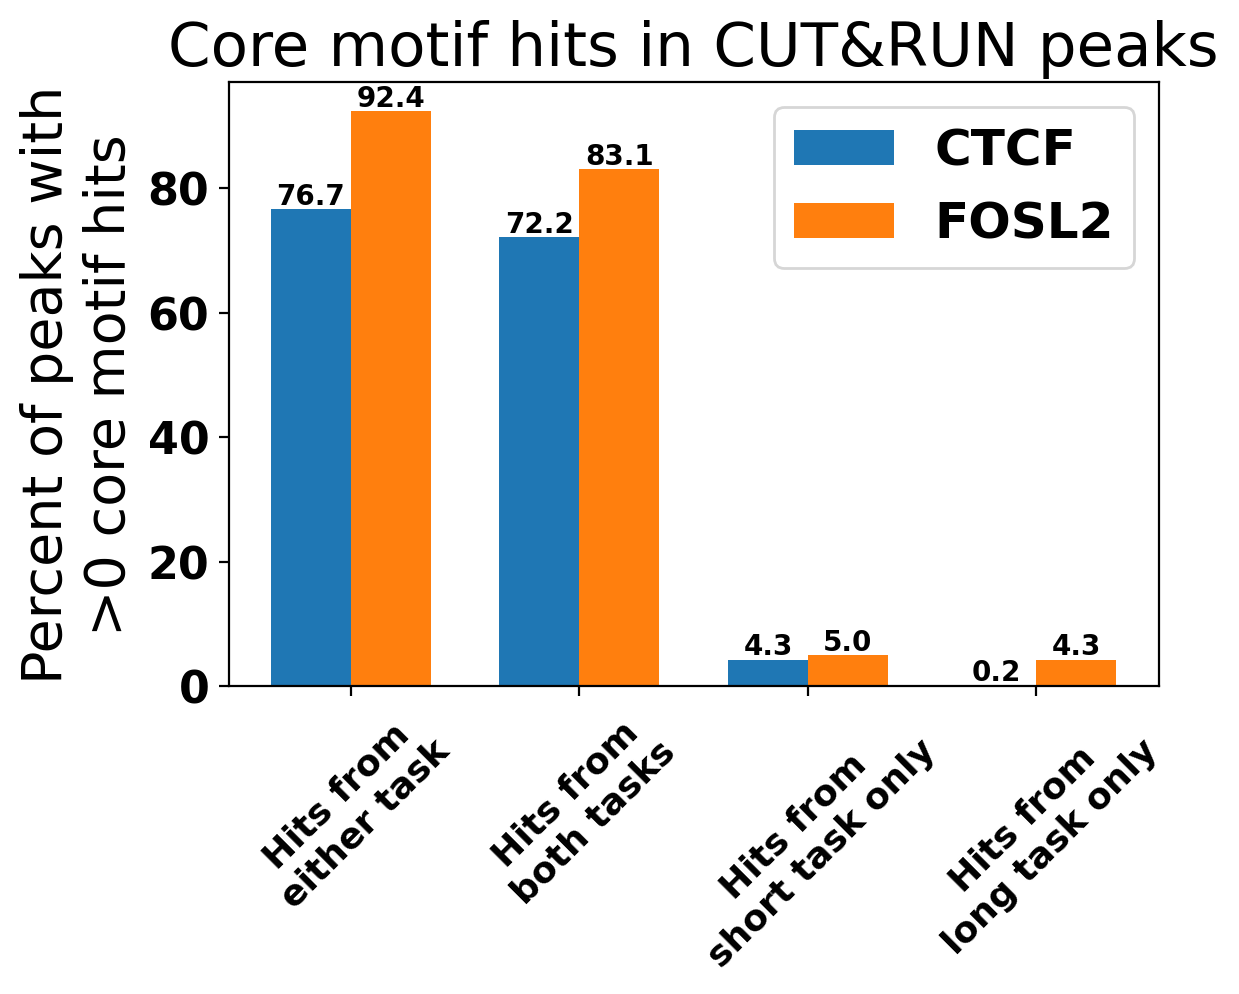

In [32]:
# order: ( % of peaks that have >0 core motif hit from EITHER TASK, 
#          % of peaks that have >0 core motif hit from BOTH TASKS)
#          % of peaks that have >0 core motif hit from ONLY SHORT TASK, 
#          % of peaks that have >0 core motif hit from ONLY LONG TASK )
ctcf_stats = (76.7, 72.2, 4.3, 0.2)
fosl2_stats = (92.4, 83.1, 5.0, 4.3)

ind = np.arange(len(ctcf_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=200)
rects1 = ax.bar(ind - width/2, ctcf_stats, width, 
                label='CTCF')
rects2 = ax.bar(ind + width/2, fosl2_stats, width,
                label='FOSL2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of peaks with\n>0 core motif hits')
ax.set_title('Core motif hits in CUT&RUN peaks')
ax.set_xticks(ind)
ax.set_xticklabels(('Hits from\neither task', 'Hits from\nboth tasks', 'Hits from\nshort task only', 
                    'Hits from\nlong task only'), rotation=45, fontsize=13)
ax.legend()

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")
plt.show()

### Do the motif hits from the short task tend to overlie DNase-seq peaks, whereas the long task motif hits tend to be outside DNase-seq peaks?

In [36]:
dnase_peaks = import_peak_table(['/home/katie/bp_repo/research/data/ENCFF274YGF.bed'])

In [40]:
import joblib
def get_motif_hits_in_dnase_peaks(hit_table, dnase_peaks):
    '''
    USE THIS! From a table of motif hits, finds how many overlap a dnase peak.
    
    Input:
    hit_table: pd dataframe of motif hits
    dnase_peaks: pd dataframe of peaks
    
    Output:
    (integer of how many motif hits overlap a dnase peak, float of percent of motif hits overlapping a dnase peak)
    '''
    num_hits_overlapping_dnase = 0
    
    #for index, hit in tqdm.tqdm_notebook(hit_table.iterrows()):
    for index, hit in hit_table.iterrows():
        conditions = (hit.chrom == dnase_peaks.chrom) & (hit.start >= dnase_peaks.peak_start) & (hit.end <= dnase_peaks.peak_end)
        if len(dnase_peaks[conditions]) > 0:
            num_hits_overlapping_dnase += 1 
            
    percent_hits_overlapping_dnase = num_hits_overlapping_dnase / len(hit_table)
    return num_hits_overlapping_dnase, percent_hits_overlapping_dnase

In [41]:
hit_table_filtered_max_0_0_SPLIT = np.array_split(hit_table_filtered_max_0_0, 64)
out_max = joblib.Parallel(n_jobs=64)(joblib.delayed(get_motif_hits_in_dnase_peaks)(hit_table, dnase_peaks) for 
                                 hit_table in hit_table_filtered_max_0_0_SPLIT)

hit_table_filtered_min_0_0_SPLIT = np.array_split(hit_table_filtered_min_0_0, 64)
out_min = joblib.Parallel(n_jobs=64)(joblib.delayed(get_motif_hits_in_dnase_peaks)(hit_table, dnase_peaks) for 
                                 hit_table in hit_table_filtered_min_0_0_SPLIT)

num_overlaps_max_0_0, percent_overlaps_max_0_0 = sum(num_hits[0] for num_hits in out_max), sum(num_hits[0] for num_hits in out_max) / len(hit_table_filtered_max_0_0)
num_overlaps_min_0_0, percent_overlaps_min_0_0 = sum(num_hits[0] for num_hits in out_min), sum(num_hits[0] for num_hits in out_min) / len(hit_table_filtered_min_0_0)

In [54]:
dicty = {'Number of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': num_overlaps_min_0_0,
      'Percent of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': percent_overlaps_min_0_0}
dicty

{'Number of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 13733,
 'Percent of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 0.15577182654461724}

In [55]:
import pickle
pickle.dump(dicty, open('/home/katie/bp_repo/reports/dnase_motif_hits/fosl2_minfl150_0_0_COUNTS_HEAD', 'wb'))

#### Analysis of DNase peak overlap with motif hits

In [47]:
import pickle

In [56]:
with open('/home/katie/bp_repo/reports/dnase_motif_hits/ctcf_maxfl120_0_0_COUNTS_HEAD', 'rb') as f:
    ctcf_maxfl120_0_0 = pickle.load(f)
with open('/home/katie/bp_repo/reports/dnase_motif_hits/ctcf_minfl150_0_0_COUNTS_HEAD', 'rb') as f:
    ctcf_minfl150_0_0 = pickle.load(f)
with open('/home/katie/bp_repo/reports/dnase_motif_hits/fosl2_maxfl120_0_0_COUNTS_HEAD', 'rb') as f:
    fosl2_maxfl120_0_0 = pickle.load(f)
with open('/home/katie/bp_repo/reports/dnase_motif_hits/fosl2_minfl150_0_0_COUNTS_HEAD', 'rb') as f:
    fosl2_minfl150_0_0 = pickle.load(f)

In [62]:
ctcf_maxfl120_0_0

{'Number of motif hits from maxfl120 task with motif key 0_0 overlapping a DNase peak': 52186,
 'Percent of motif hits from maxfl120 task with motif key 0_0 overlapping a DNase peak': 0.6208332341954365}

In [63]:
ctcf_minfl150_0_0

{'Number of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 32810,
 'Percent of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 0.6253692938149242}

In [64]:
fosl2_maxfl120_0_0

{'Number of motif hits from maxfl120 task with motif key 0_0 overlapping a DNase peak': 15169,
 'Percent of motif hits from maxfl120 task with motif key 0_0 overlapping a DNase peak': 0.17715620437956203}

In [65]:
fosl2_minfl150_0_0

{'Number of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 13733,
 'Percent of motif hits from minfl150 task with motif key 0_0 overlapping a DNase peak': 0.15577182654461724}

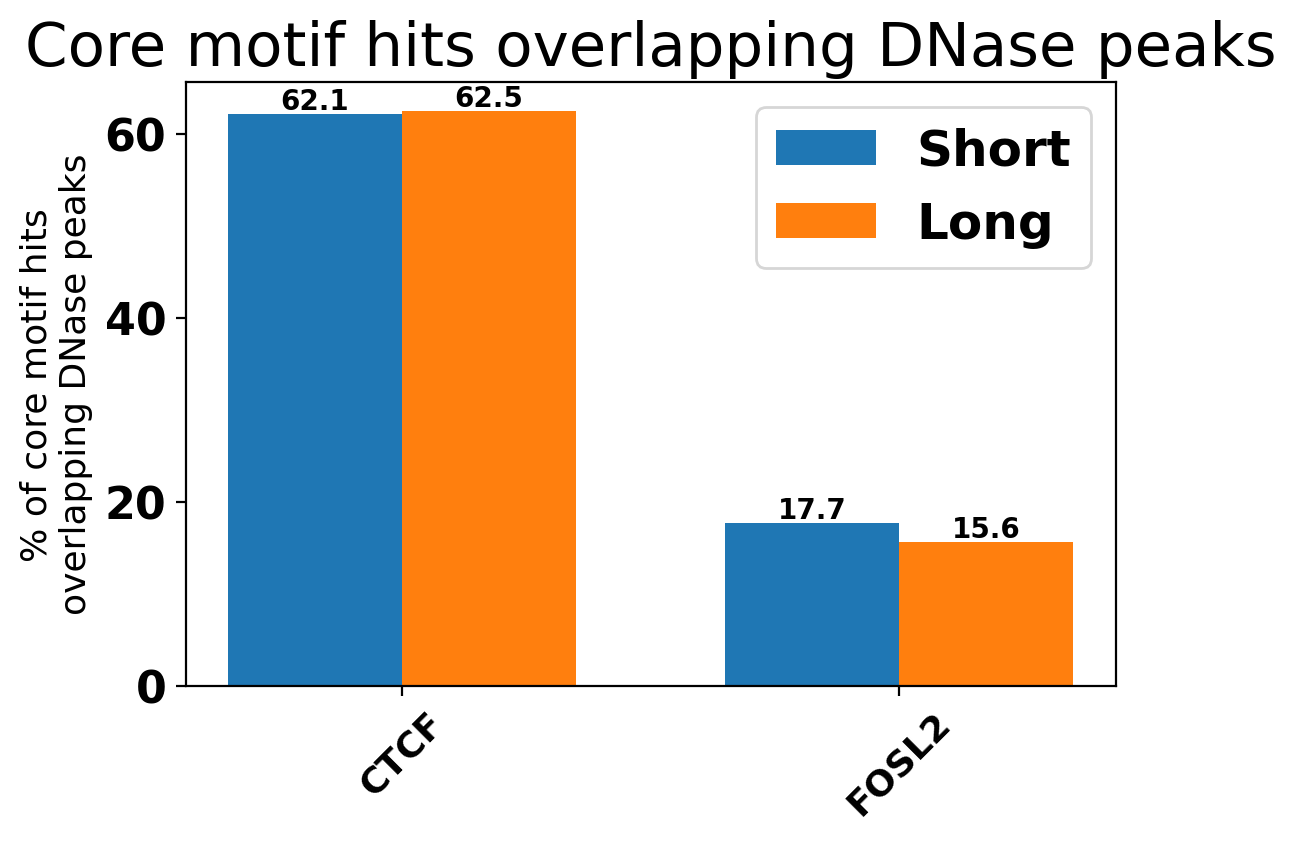

In [66]:
# order: ( % of SHORT motif hits from ctcf, fosl2 with key 0_0 overlapping a dnase peak, 
#          % of LONG motif hits from ctcf, fosl2 with key 0_0 overlapping a dnase peak)
ctcf_stats = (62.1, 17.7)
fosl2_stats = (62.5, 15.6)

ind = np.arange(len(ctcf_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=200)
rects1 = ax.bar(ind - width/2, ctcf_stats, width, 
                label='Short')
rects2 = ax.bar(ind + width/2, fosl2_stats, width,
                label='Long')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of core motif hits\noverlapping DNase peaks', fontsize=13)
ax.set_title('Core motif hits overlapping DNase peaks')
ax.set_xticks(ind)
ax.set_xticklabels(('CTCF', 'FOSL2'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()